In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

### Load the data

In [8]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train.csv')
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

### Data exploration
Print Schema in a tree format.

In [10]:
house_df.cache()

DataFrame[ID: int, crim: double, zn: double, indus: double, chas: int, nox: double, rm: double, age: double, dis: double, rad: int, tax: int, ptratio: double, black: double, lstat: double, medv: double]

In [11]:
house_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [12]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


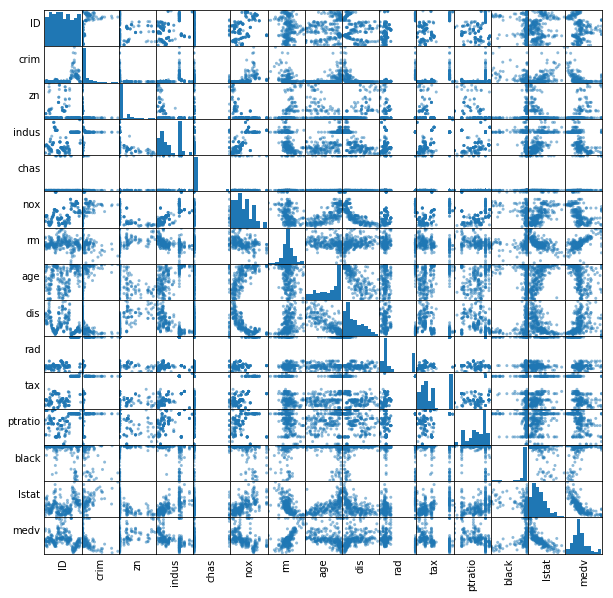

In [33]:
import pandas as pd
# return here again
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())


Find correlation between independent variables and target variable.
The correlation is between 0 –1 to 1. When it is close to 1 there is a strong positive correlation; for example, the median value tends to go up when the number of rooms goes up. When the coefficient is close to –1, it means there is a strong negative correlation and when coefficients close to zero mean that there is no linear correlation.

In [32]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to medv for ", i, house_df.stat.corr('medv',i))


Correlation to medv for  ID -0.22169418651611697
Correlation to medv for  crim -0.4074543235732598
Correlation to medv for  zn 0.34484197569664277
Correlation to medv for  indus -0.47393197065920345
Correlation to medv for  chas 0.20438998859918733
Correlation to medv for  nox -0.4130541519920783
Correlation to medv for  rm 0.6895980892872156
Correlation to medv for  age -0.35888827406190227
Correlation to medv for  dis 0.24942226829396397
Correlation to medv for  rad -0.3522508242456341
Correlation to medv for  tax -0.44807769440070433
Correlation to medv for  ptratio -0.48137595552491735
Correlation to medv for  black 0.33665955532155767
Correlation to medv for  lstat -0.7386000348786346
Correlation to medv for  medv 1.0


###  Data prep for ml
we need two columns features and label(“medv”):

In [73]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['ID','crim','zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df=vectorAssembler.transform(house_df).select(['features','medv'])
vhouse_df.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[1.0,0.00632,18.0...|24.0|
|[2.0,0.02731,0.0,...|21.6|
|[4.0,0.03237,0.0,...|33.4|
|[5.0,0.06905,0.0,...|36.2|
|[7.0,0.08829,12.5...|22.9|
+--------------------+----+
only showing top 5 rows



In [93]:

splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

DataFrame[features: vector, medv: double]

### LR

In [94]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [0.0,0.0,0.008396048424079296,0.0,4.364700758728272,-6.746971472344359,3.7396391717867425,0.0,-0.7302888212641605,0.0,-0.00041205412964661557,-0.44883123632561955,0.009553390978154705,-0.6153811039460064]
Intercept: 17.959375026562267


Summarize the model over the training set and print out some metrics:

In [88]:
trainingSummary = lr_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 11
RMSE: 5.032153
r2: 0.691617


In [77]:
train_df.describe().show()


+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               238|
|   mean|22.801260504201693|
| stddev| 9.080774335894825|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [89]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|25.166645317758146|21.6|[2.0,0.02731,0.0,...|
|29.489429850152693|33.4|[4.0,0.03237,0.0,...|
|23.226255563804372|23.1|[17.0,1.05393,0.0...|
|13.325226215117542|13.6|[21.0,1.25179,0.0...|
| 19.19986412269105|19.6|[22.0,0.85204,0.0...|
+------------------+----+--------------------+
only showing top 5 rows



buradan sonrası kopyala yapıstır 

In [90]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.750885


In [91]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.6918
